# Libraries

In [5]:
import os
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from prettytable import PrettyTable

# Constants

In [6]:
FOLDER_PATH = './gas_consumption/'
FILE_EXSTENSION = '.json'
GAS_PRICE = 200000000000 # 0.00000002 ETH

## Showing Results
**Important**: the cost is computed taking in account the gas price equal to 20. <br> So the formula to computed it is the following: <br> <br>ETH_PRICE = GAS_PRICE * TOTAL_GAS_USED * 1e-18 <br> <br>where 1e-18 is the conversion from Wei to Etherum,
if we use 1e-9 is the conversion from Wei to Gwei

In [56]:
def adjusting_dict(collaborator_data, device):
    len_retrieve = len(collaborator_data[device]['retrieve_fee'])
    len_send = len(collaborator_data[device]['send_fee'])

    collaborator_data[device]['get_weights'] = collaborator_data[device].pop('retrieve_fee')
    collaborator_data[device]['send_weights'] = collaborator_data[device].pop('send_fee')

    collaborator_data[device]['get_weights'] = int(np.sum(np.array(collaborator_data[device]['get_weights'],dtype=int))) if collaborator_data[device]['get_weights'] != [] else 0
    collaborator_data[device]['send_weights'] = int(np.sum(np.array(collaborator_data[device]['send_weights'],dtype=int))) if collaborator_data[device]['send_weights'] != [] else 0
    # computing the mean
    collaborator_data[device]['mean_retrieve'] = int(collaborator_data[device]['get_weights'] / len_retrieve) if len_retrieve != 0 else 0

    collaborator_data[device]['mean_send'] = int(collaborator_data[device]['send_weights'] / len_send) if len_send != 0 else 0
    collaborator_data[device]['total_gas'] = int(collaborator_data[device]['get_weights'] + collaborator_data[device]['send_weights'] + collaborator_data[device]['model_start_fee'])

    collaborator_data[device]['model_start'] = collaborator_data[device].pop('model_start_fee')

    x = round((collaborator_data[device]['total_gas'] * GAS_PRICE) * 1e-18,4)
    collaborator_data[device]['ETH'] = x
    return collaborator_data

def manager_adj(manager_data):
    manager_data['send_aggregated_weights_fee'] = np.unique(manager_data['send_aggregated_weights_fee'])
    manager_data['send_weights'] = manager_data.pop('send_aggregated_weights_fee')
    manager_data['add_collaborator'] = manager_data.pop('add_collaborator_fee')
    manager_data['open_blockchain'] = manager_data.pop('open_blockchain_fee')
    manager_data['change_state'] = manager_data.pop('change_state_fee')
    manager_data['send_model'] = manager_data.pop('send_model_fee')
    manager_data['deployment'] = manager_data.pop('deploy_mocks_fee')
    return  manager_data

def collaborator_conversion(df):
    pretty_table = PrettyTable(['Fees'] + df.columns.tolist())  # Set columns as headers
    for row in df.itertuples():
        #pretty_table.add_row([row.Index] + [int(row[col]) if col not in ['ETH'] else row[col] for col in df.columns.tolist()])
        pretty_table.add_row([row.Index] + list(row)[1:])
    return pretty_table

def manager_conversion(df):
    pretty_table = PrettyTable(df.columns.tolist())  # Set column names as headers
    for row in df.itertuples(index=False):
        pretty_table.add_row(row)
    return pretty_table

In [61]:
all_files = os.listdir(FOLDER_PATH)

# Filter files based on the pattern Name*_collaborator.json and Name*_manager.json
collaborator_files = [file for file in all_files if '_collaborator' in file]
manager_files = [file for file in all_files if '_manager' in file]

collaborators = []
managers = []
for collaborator_file, manager_file in zip(collaborator_files, manager_files):
    collaborator_path = os.path.join(FOLDER_PATH, collaborator_file)
    manager_path = os.path.join(FOLDER_PATH, manager_file)

    # Load JSON data from files
    with open(collaborator_path, 'r') as f_collaborator, open(manager_path, 'r') as f_manager:
        collaborator_data = json.load(f_collaborator)
        manager_data = json.load(f_manager)

    for device in collaborator_data.keys():
        collaborator_data = adjusting_dict(collaborator_data, device)

    sum_send_aggr_weights = np.sum(np.array(manager_data['send_aggregated_weights_fee']))
    total_cost = sum_send_aggr_weights + np.sum(np.array([value for key,value in manager_data.items() if key !=  'send_aggregated_weights_fee' ]))

    manager_data['total_gas'] =total_cost
    manager_data['ETH'] = round((total_cost * GAS_PRICE) * 1e-18, 4)
    manager_data = manager_adj(manager_data)
    collaborators.append(collaborator_data)
    managers.append(manager_data)
    collaborator_df = pd.DataFrame.from_dict(collaborator_data, orient='index').T
    manager_df = pd.DataFrame.from_dict(manager_data, orient='index').T
    name_file = collaborator_file.split('_')
    # Print DataFrames
    print(f"\t\t\tFees for {name_file[-3]} devices and {name_file[-2]} out of battery:\n")
    collaborator_table = collaborator_conversion(collaborator_df)
    collaborator_table.title = "Collaborator Fees"
    print(collaborator_table)
    print()
    print()
    manager_table = manager_conversion(manager_df)
    manager_table.title = "Manager Fees"
    print(manager_table)

    print("\n" + "=" * 100 + "\n")


			Fees for 3 devices and ['A'] out of battery:

+--------------------------------------------------+
|                Collaborator Fees                 |
+---------------+----------+-----------+-----------+
|      Fees     |    A     |     B     |     C     |
+---------------+----------+-----------+-----------+
|  get_weights  |   0.0    |  283788.0 |  307107.0 |
|  send_weights | 155983.0 | 1555740.0 | 1313546.0 |
| mean_retrieve |   0.0    |  31532.0  |  34123.0  |
|   mean_send   | 155983.0 |  155574.0 |  131354.0 |
|   total_gas   | 306308.0 | 1965035.0 | 1755122.0 |
|  model_start  | 150325.0 |  125507.0 |  134469.0 |
|      ETH      |  0.0613  |   0.393   |   0.351   |
+---------------+----------+-----------+-----------+


+------------------------------------------------------------------------------------------------------------------+
|                                                   Manager Fees                                                   |
+-----------+--------+----

			Fees for 3 devices and ['A'] out of battery:



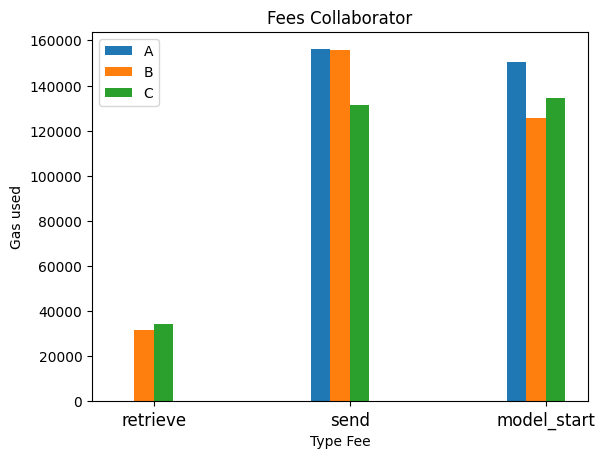

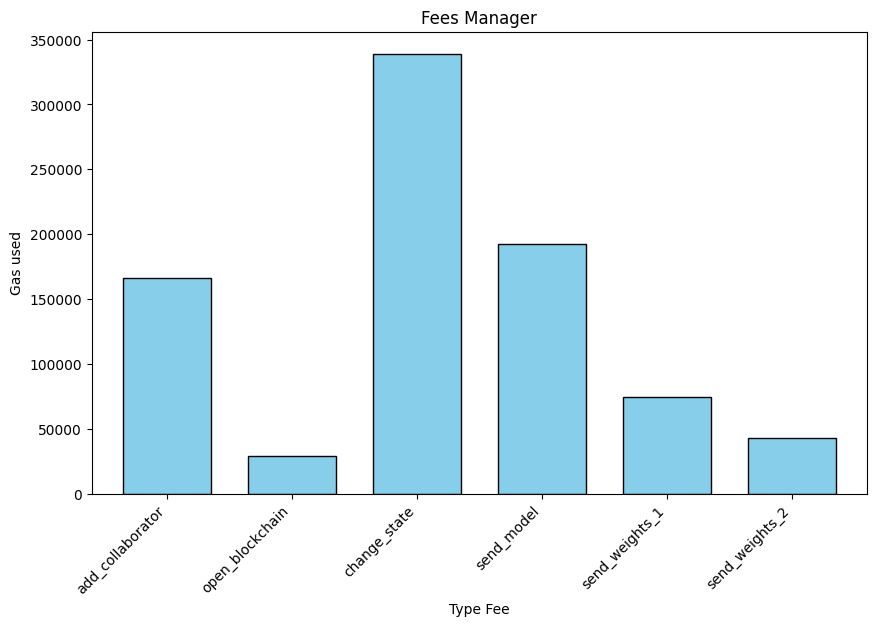



			Fees for 3 devices and [] out of battery:



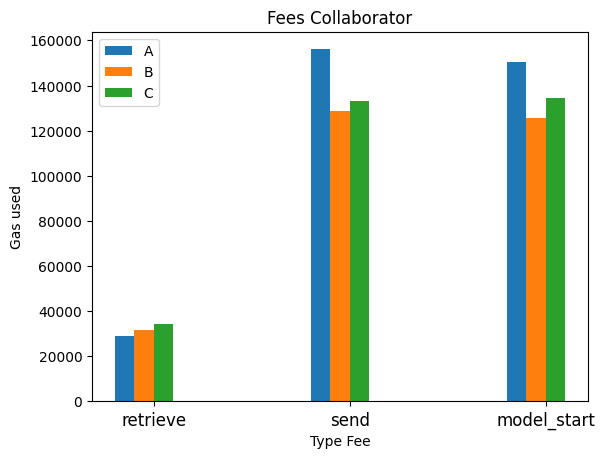

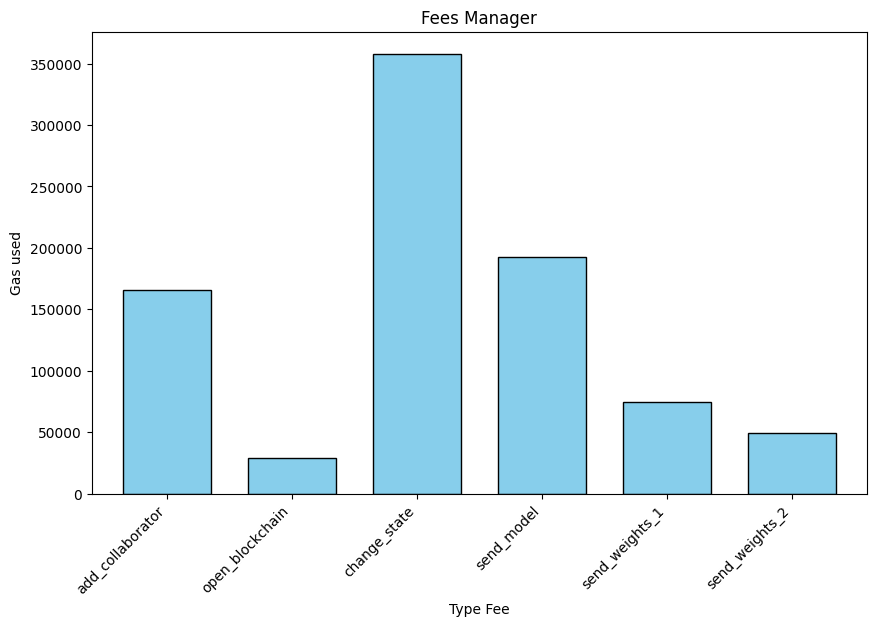



			Fees for 4 devices and ['A', 'C'] out of battery:



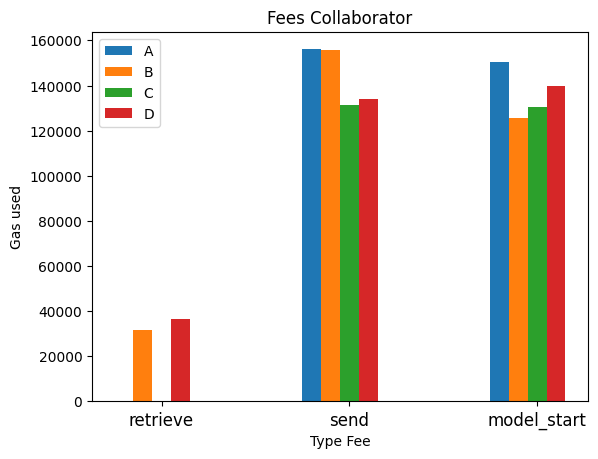

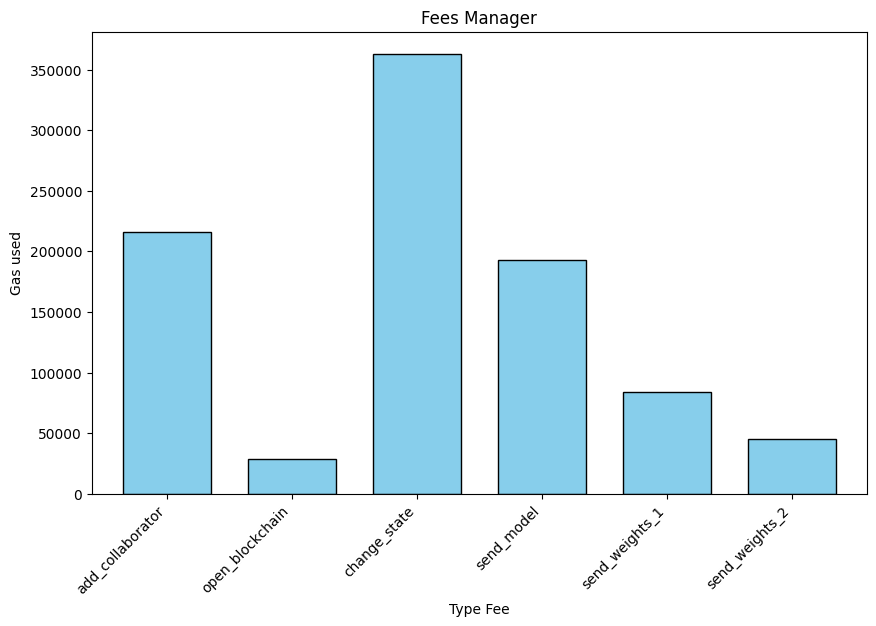



			Fees for 4 devices and [] out of battery:



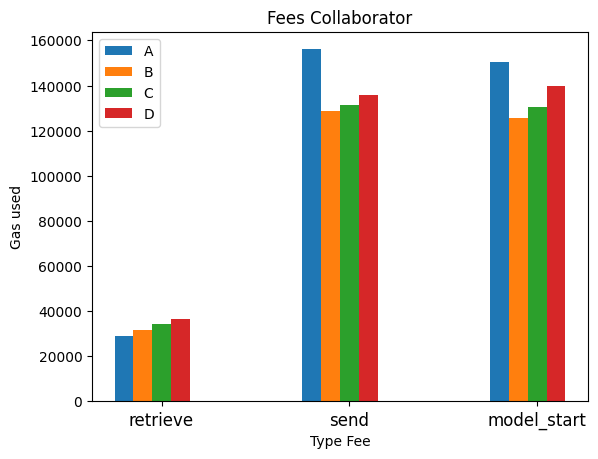

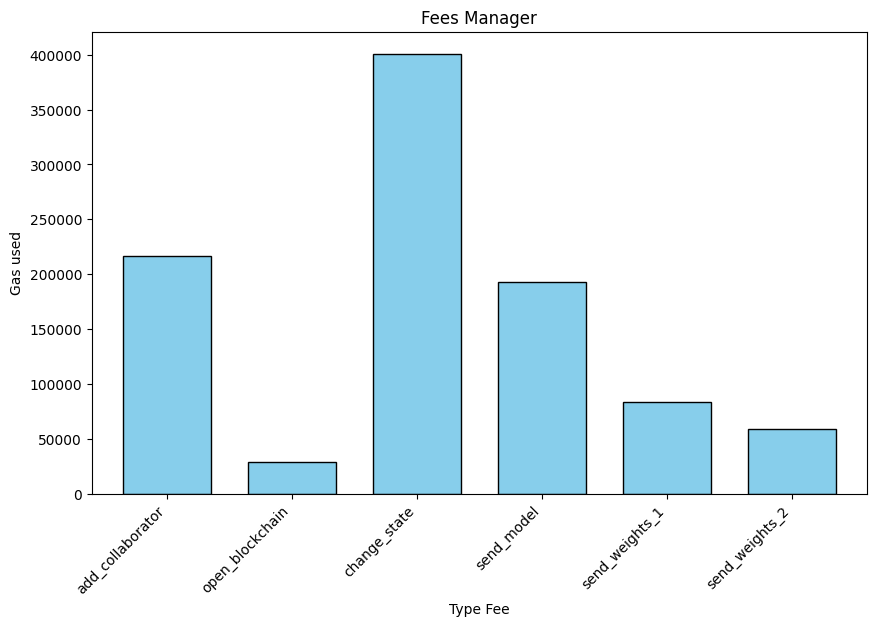



			Fees for 5 devices and [] out of battery:



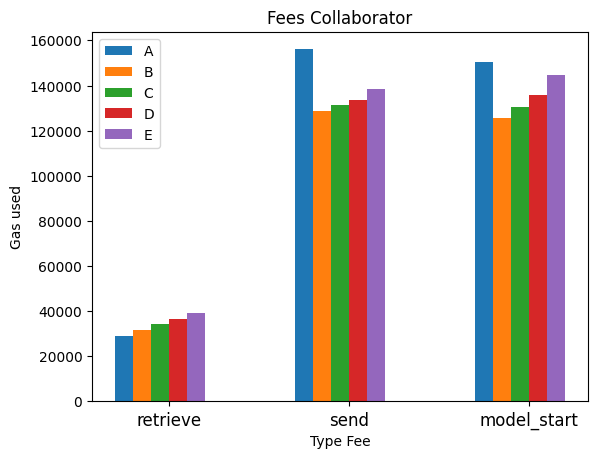

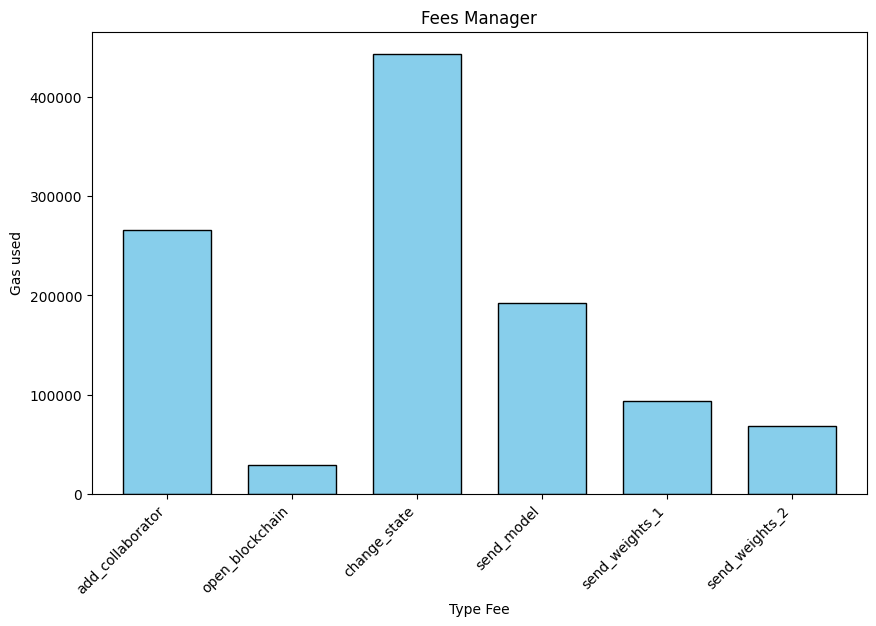



			Fees for 6 devices and ['F', 'A', 'C'] out of battery:



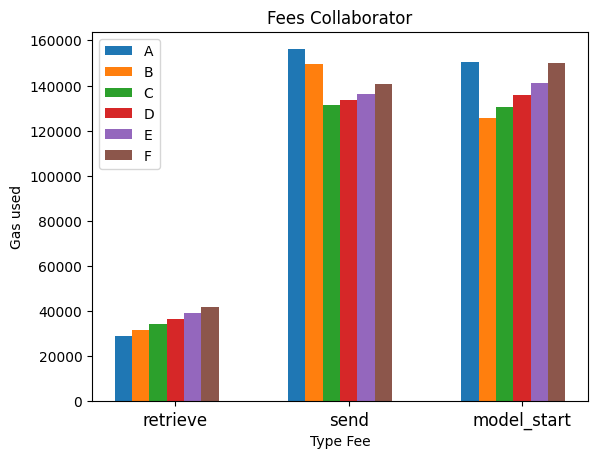

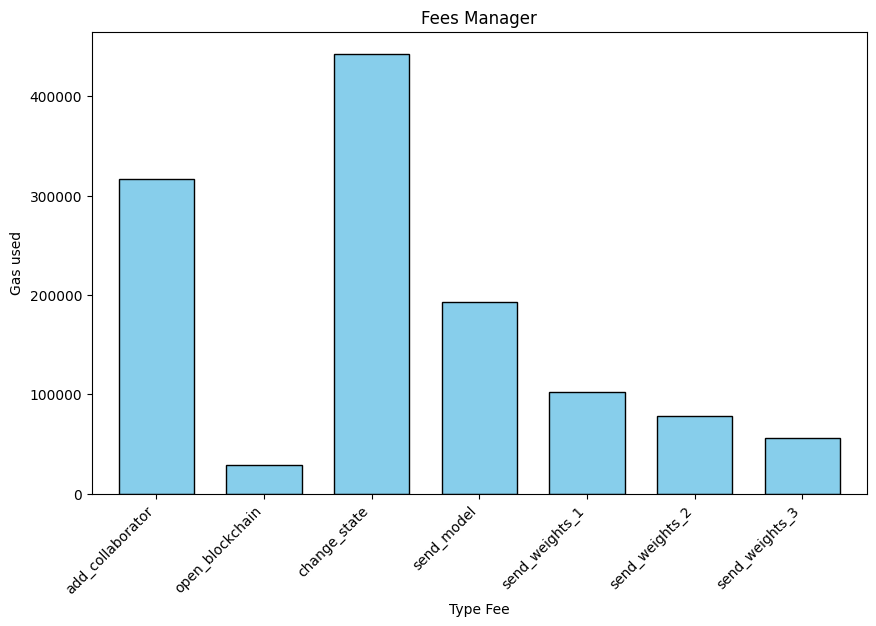



			Fees for 6 devices and [] out of battery:



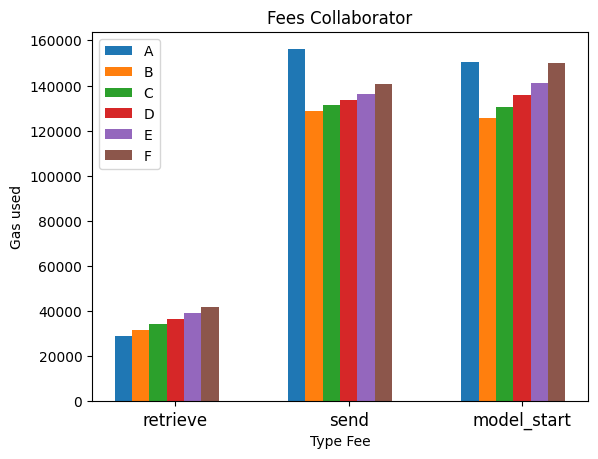

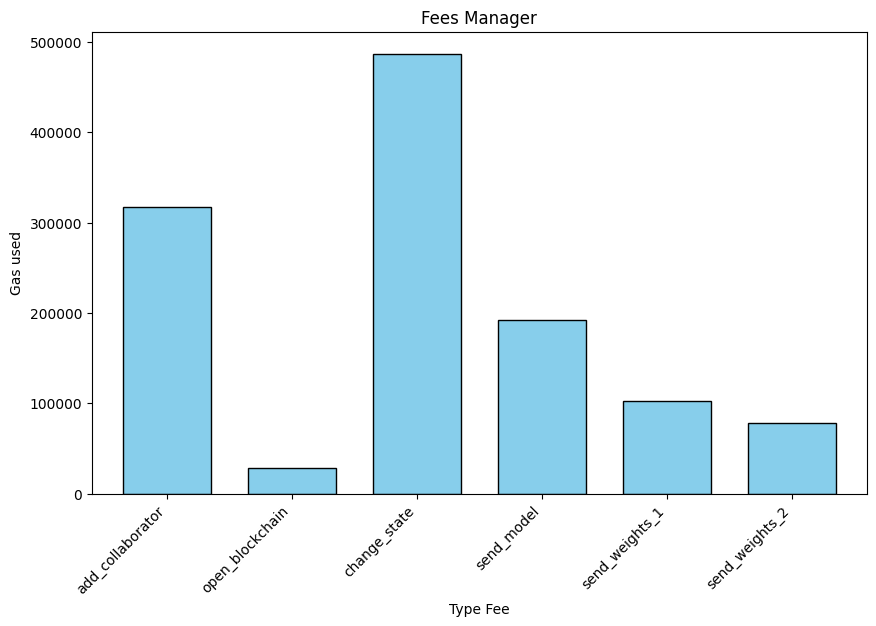



			Fees for 7 devices and [] out of battery:



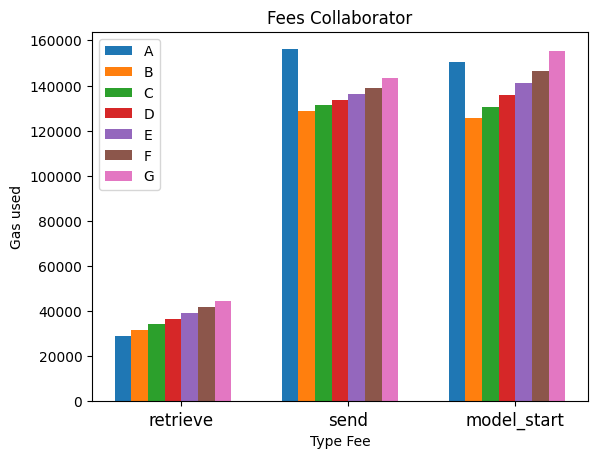

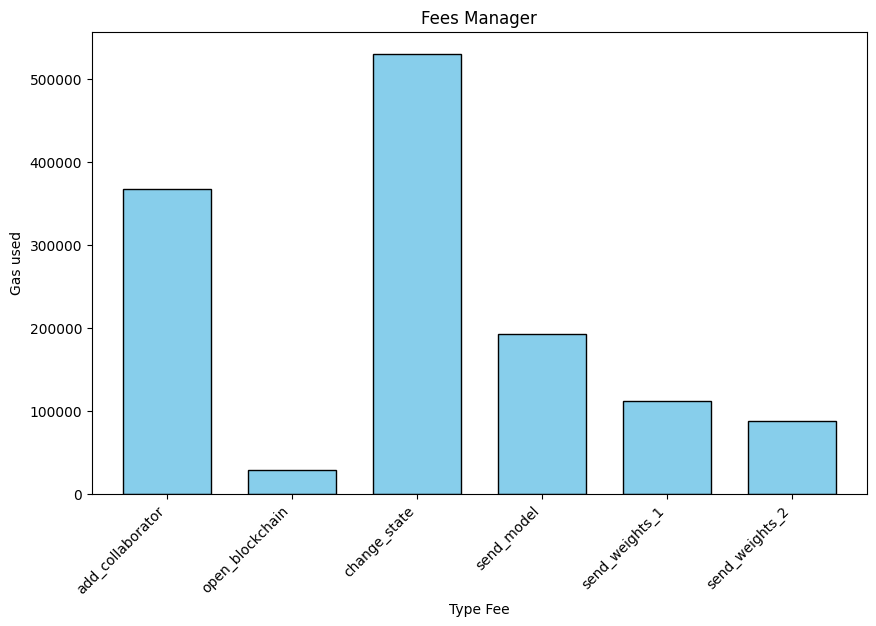



			Fees for 8 devices and ['B', 'A', 'E'] out of battery:



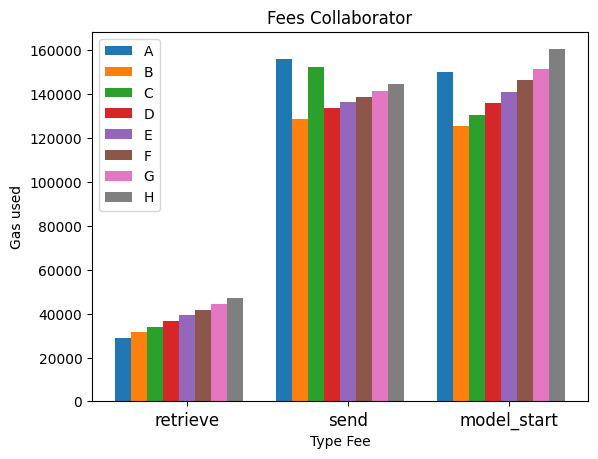

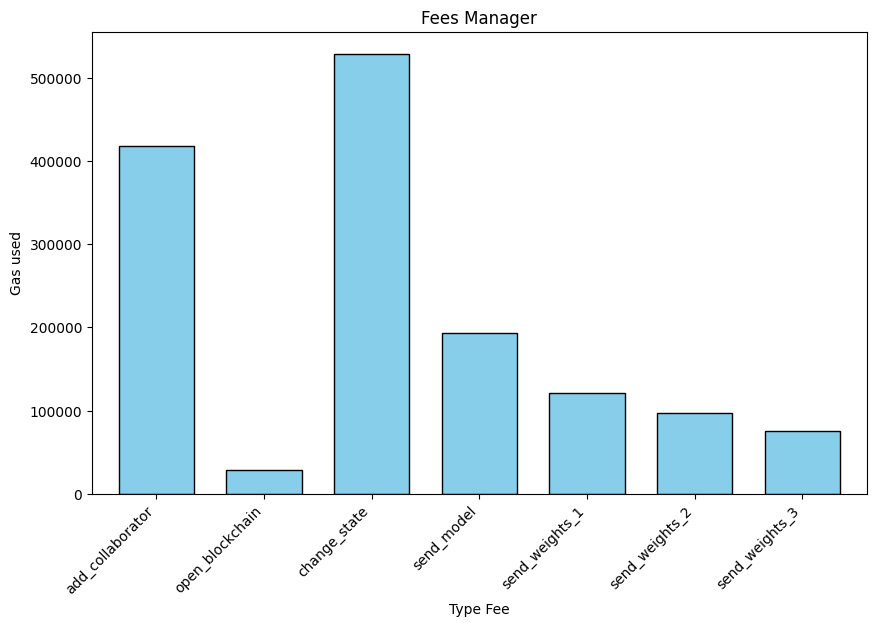



			Fees for 8 devices and [] out of battery:



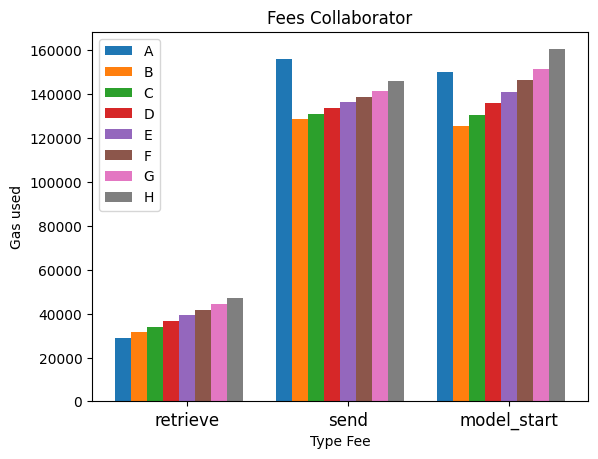

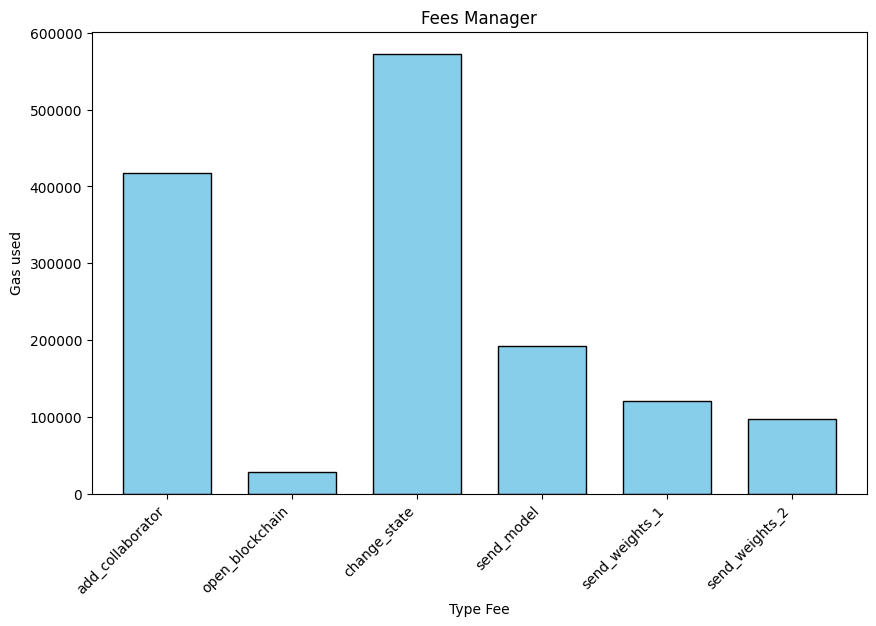



			Fees for 9 devices and ['B', 'A', 'E', 'D'] out of battery:



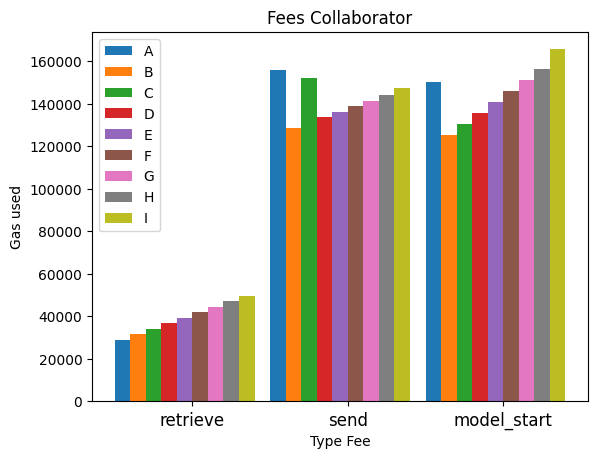

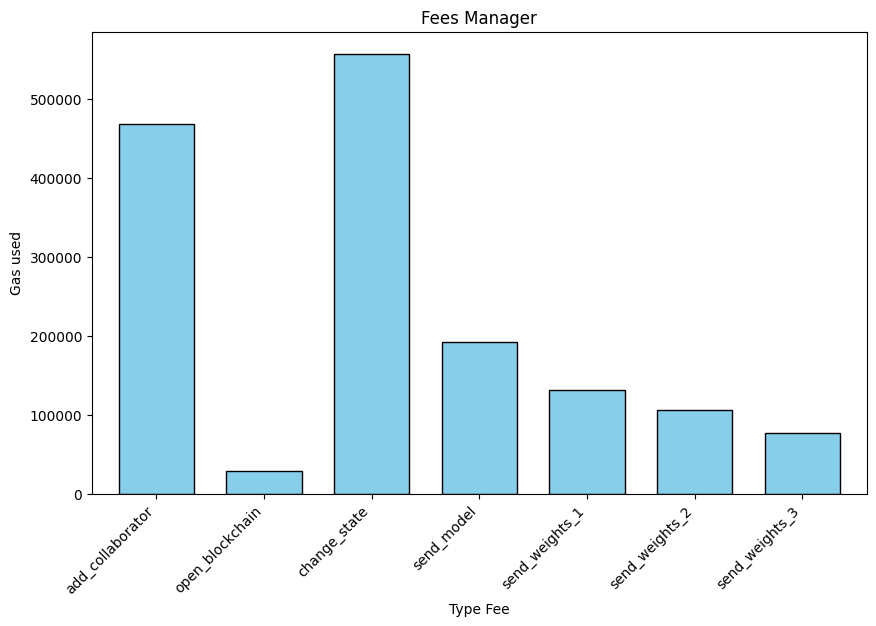



			Fees for 9 devices and [] out of battery:



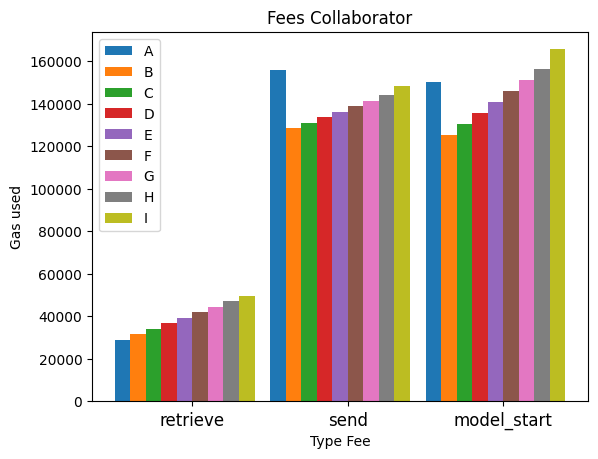

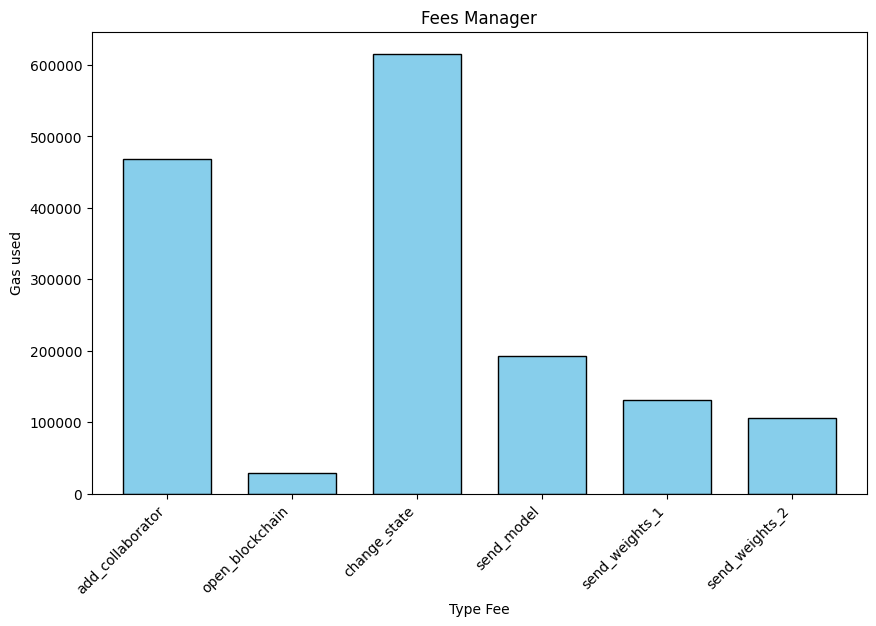

In [60]:
for collaborator_file, manager_file in zip(collaborator_files, manager_files):
    collaborator_path = os.path.join(FOLDER_PATH, collaborator_file)
    manager_path = os.path.join(FOLDER_PATH, manager_file)

    # Load JSON data from files
    with open(collaborator_path, 'r') as f_collaborator, open(manager_path, 'r') as f_manager:
        collaborator_data = json.load(f_collaborator)
        manager_data = json.load(f_manager)

    for device in collaborator_data.keys():
        collaborator_data = adjusting_dict(collaborator_data, device)

    sum_send_aggr_weights = np.sum(np.array(manager_data['send_aggregated_weights_fee']))


    manager_data = manager_adj(manager_data)

    name_file = collaborator_file.split('_')
    print(f"\t\t\tFees for {name_file[-3]} devices and {name_file[-2]} out of battery:\n")


    keys = ['mean_retrieve', 'mean_send', 'model_start']
    keys_name = ['retrieve', 'send', 'model_start']
    bar_width = 0.1  # Width of each bar
    bar_positions = np.arange(len(keys))  # x-axis positions for bars

    for i, device in enumerate(collaborator_data.keys()):
        values = [collaborator_data[device][key] for key in keys]
        plt.bar(bar_positions + i * bar_width, values, width=bar_width, label=device)

    plt.xticks(bar_positions + (len(collaborator_data) / 2) * bar_width, keys_name, fontsize=12)
    #plt.xticks(bar_positions + (len(collaborator_data) / 2) * bar_width, keys)
    plt.xlabel('Type Fee')
    plt.ylabel('Gas used')
    plt.title('Fees Collaborator')
    plt.legend()
    plt.show()

    manager_data.pop('deployment', None)

    # Extract and sort the 'send_weights' array
    sorted_send_weights = sorted(manager_data['send_weights'],reverse=True)

    # Add new keys to the dictionary
    for i, value in enumerate(sorted_send_weights, start=1):
        new_key = f'send_weights_{i}'
        manager_data[new_key] = value

    manager_data.pop('send_weights', None)

    df = pd.DataFrame(list(manager_data.items()), columns=['Key', 'Value'])

    df.set_index('Key', inplace=True)

    # Plot the DataFrame with different colors for each bar
    df.plot(kind='bar', figsize=(10, 6), width=0.7, edgecolor='black',color="skyblue",legend=None)
    plt.title('Fees Manager')
    plt.ylabel('Gas used')
    plt.xlabel('Type Fee')
    plt.xticks(rotation=45, ha='right')
    plt.show()

    print("\n" + "=" * 100 + "\n")
